In [4]:
import glob
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom  # working with dicom
from skimage import filters, measure, morphology, segmentation

In [5]:
img_dir = 'C:\\Users\\br_go\\Desktop\\CODE\\images'
data_path = os.path.join(img_dir, '*dcm')
files = glob.glob(data_path)
data = [] #list of original images

for file in files:
    dicom_file = pydicom.dcmread(file)
    img_array = dicom_file.pixel_array
    data.append(img_array) 

In [6]:
roi_1 = data[0][900:1200, 2600:2900]
roi_2 = data[1][1650:2150, 0:550]
roi_3 = data[2][2130:2360, 2270:2550] 

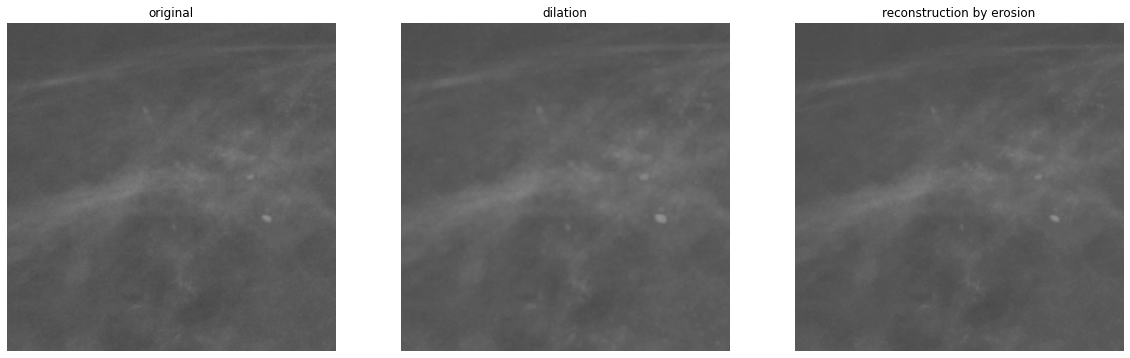

In [7]:
img = np.copy(roi_1)
img = img/4095

se = np.ones((3,3), np.uint16)
imD = morphology.dilation(img, footprint=se)
imR = morphology.reconstruction(seed=imD, mask=img, method='erosion', footprint=se)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(20,20))
ax[0].imshow(img*4095, cmap='gray', vmin=0, vmax=4095)
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(imD*4095, cmap='gray', vmin=0, vmax=4095)
ax[1].axis('off')
ax[1].set_title('dilation')
ax[2].imshow(imR*4095, cmap='gray', vmin=0, vmax=4095)
ax[2].axis('off')
ax[2].set_title('reconstruction by erosion')
plt.show()


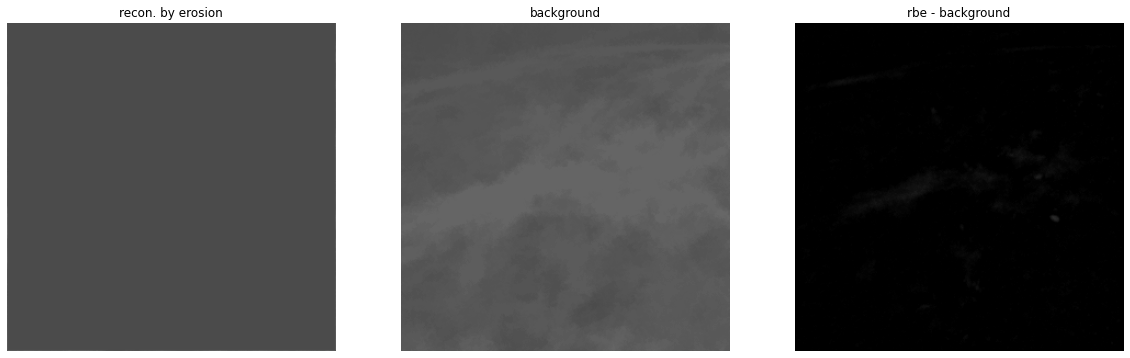

In [8]:
seed = np.copy(imR)
seed[1:-1, 1:-1] = imR.min() #set its border to be the pixel values in the original image
mask = imR

dilated = morphology.reconstruction(seed, mask, method='dilation')
im_sub = (imR - dilated)

fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(20,20))
ax[0].imshow(seed*4095, cmap='gray', vmin=0, vmax=4095)
ax[0].axis('off')
ax[0].set_title('recon. by erosion')
ax[1].imshow(dilated*4095, cmap='gray', vmin=0, vmax=4095)
ax[1].axis('off')
ax[1].set_title('background')
ax[2].imshow(im_sub*4095, cmap='gray', vmin=0, vmax=4095)
ax[2].axis('off')
ax[2].set_title('rbe - background')
plt.show()

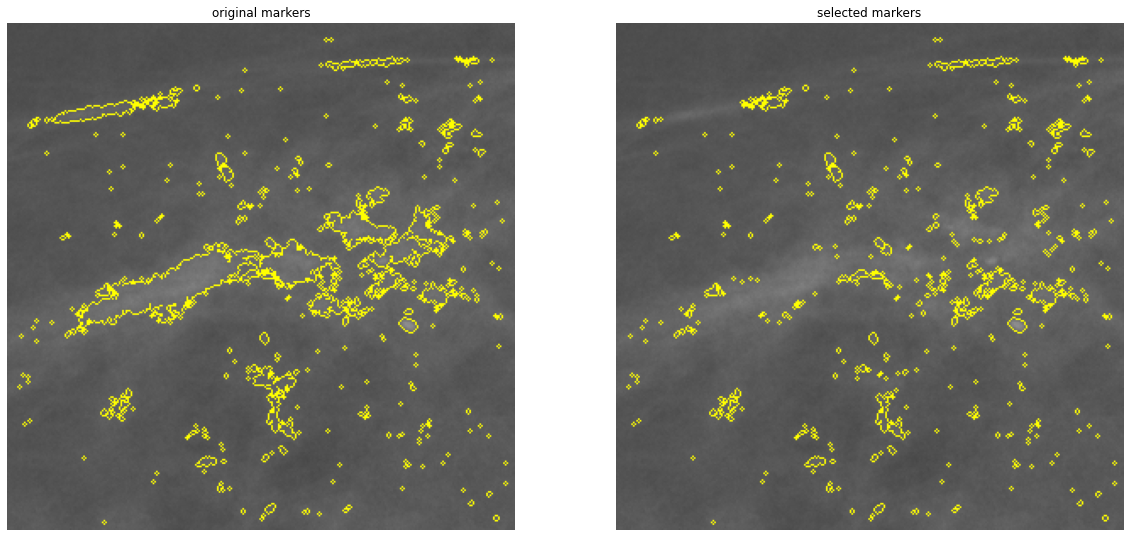

In [10]:
thresh = filters.threshold_otsu(im_sub)
intM = im_sub >= thresh #imagem binaria com os marcadores

#selecting markers
#checking local_maxima information
m_label, m_num = measure.label(intM, return_num=True, connectivity=1) #con. 1 -> 4 neighborhood
m_props = measure.regionprops(label_image=m_label, intensity_image=img)
m_props_table = measure.regionprops_table(label_image=m_label, intensity_image=img,
                                        properties=('intensity_min',
                                                    'intensity_max',
                                                    'intensity_mean',
                                                    'area',
                                                    'area_convex',
                                                    'area_bbox',
                                                    'extent',
                                                    'solidity'))

m_df = pd.DataFrame(m_props_table)

valid_markers = set()
for marker in m_props:
    m_area = marker.area <= 100
    if m_area:
        valid_markers.add(marker.label)

markers = np.in1d(m_label, list(valid_markers)).reshape(m_label.shape)
ms_label = measure.label(markers, connectivity=1)

ms_props_table = measure.regionprops_table(label_image=ms_label, intensity_image=img,
                                    properties=('intensity_min',
                                                'intensity_max',
                                                'intensity_mean',
                                                'area',
                                                'area_convex',
                                                'area_bbox',
                                                'extent',
                                                'solidity'))

ms_df = pd.DataFrame(ms_props_table)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,15))
ax[0].imshow(segmentation.mark_boundaries(img, m_label))
ax[0].axis('off')
ax[0].set_title('original markers')
ax[1].imshow(segmentation.mark_boundaries(img, ms_label))
ax[1].axis('off')
ax[1].set_title('selected markers')
plt.show()


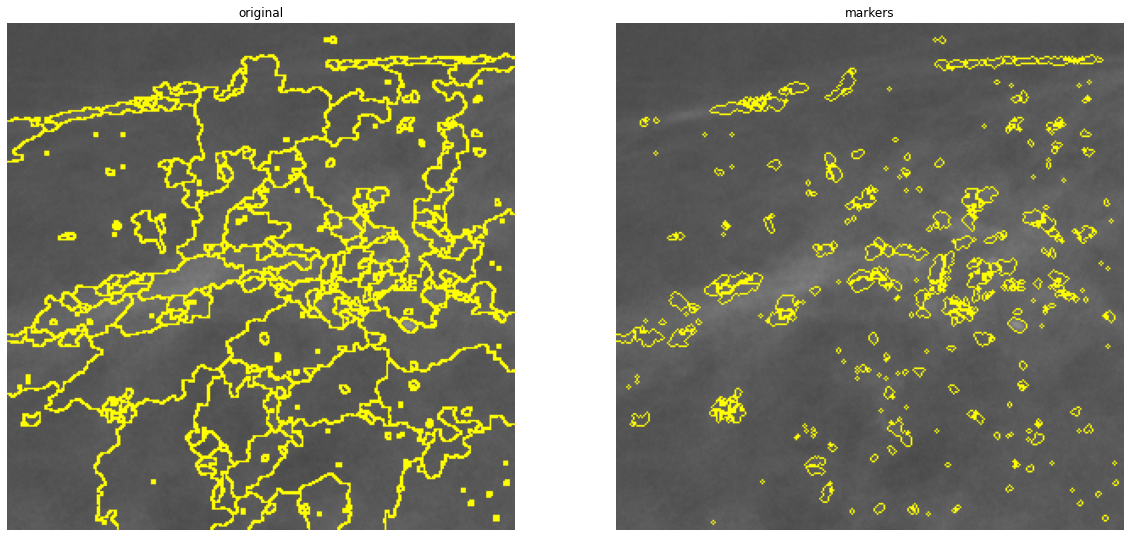

In [11]:
gmag = filters.sobel(img)
r_watershed = segmentation.watershed(gmag, markers=ms_label, watershed_line=True)
w_props = measure.regionprops(label_image=r_watershed, intensity_image=img)
w_props_table = measure.regionprops_table(label_image=r_watershed, intensity_image=img,
                                        properties=('intensity_min',
                                                    'intensity_max',
                                                    'intensity_mean',
                                                    'area',
                                                    'area_convex',
                                                    'area_bbox',
                                                    'extent',
                                                    'solidity'))

w_df = pd.DataFrame(w_props_table)

valid_regions = set()
for region in w_props:
    w_area = region.area <= 100
    if w_area:
        valid_regions.add(region.label)

regions = np.in1d(r_watershed, list(valid_regions)).reshape(r_watershed.shape)
r_label = measure.label(regions, connectivity=1)

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,15))
ax[0].imshow(segmentation.mark_boundaries(img, r_watershed))
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(segmentation.mark_boundaries(img, r_label))
ax[1].axis('off')
ax[1].set_title('markers')
plt.show()

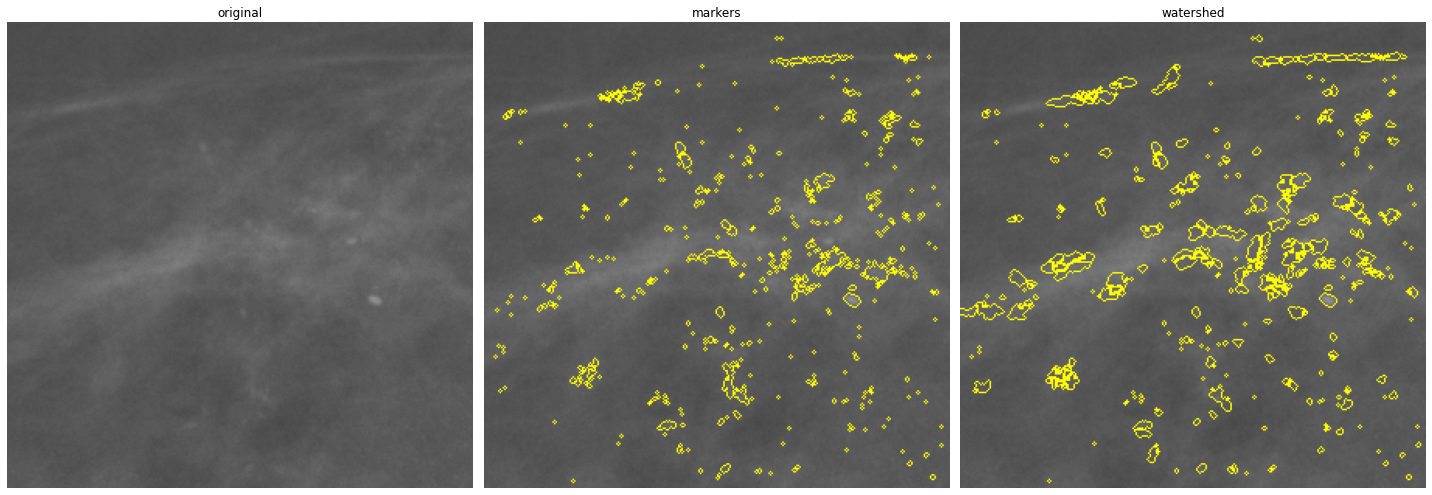

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(20,15))
ax[0].imshow(img*4095, cmap='gray', vmin=0, vmax=4095)
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(segmentation.mark_boundaries(img, ms_label))
ax[1].axis('off')
ax[1].set_title('markers')
ax[2].imshow(segmentation.mark_boundaries(img, r_label))
ax[2].axis('off')
ax[2].set_title('watershed')
plt.tight_layout()
plt.show()